# Import and define plot functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.cosmology import z_at_value

from bornraytrace import lensing

In [2]:
# Plotting functions

def plot_map_pairs(map1, map2, title1='BornRaytrace', title2='Takahashi example'):
    _ = plt.figure(figsize=(12,7))
    _ = hp.visufunc.orthview(map1, min=-0.025, max=0.025,
                         title=title1, half_sky=True,sub=(1,2,1),
                         rot = (30,20), cmap='magma')
    _ = hp.visufunc.orthview(map2, min=-0.025, max=0.025,
                         title=title2, half_sky=True,sub=(1,2,2),
                         rot = (30,20), cmap='magma')
    _ = hp.graticule(True, verbose=False)

# Load simulation as overdensity healpix maps

In [3]:
nside = 512
z_bin_edges = np.genfromtxt('takahashi_mock_example/z.txt')
overdensity_array = np.load('takahashi_mock_example/takahashi_overdensity_array.npy')

In [4]:
cosmo_taka = FlatLambdaCDM(H0= 70 * u.km / u.s / u.Mpc, Om0=(0.233+0.046))

/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are mod

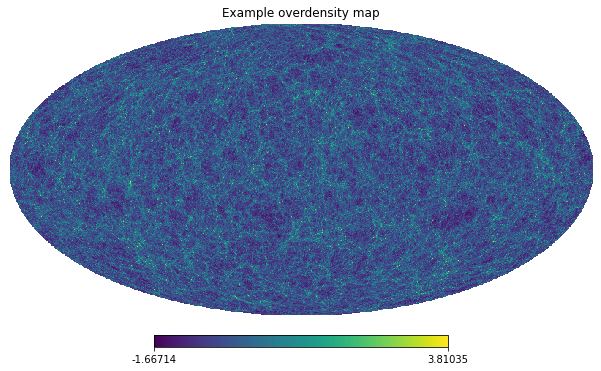

In [5]:
hp.mollview(np.log(overdensity_array[1] + 1), title='Example overdensity map')

# Calculate lensing convergence

### Define source galaxy plane 

In [6]:
source_edge_index = 20
z_source = z_bin_edges[source_edge_index]
print(z_source)

1.5345


### Define the centres of the comoving overdensity shells

In [7]:
comoving_edges =  cosmo_taka.comoving_distance(z_bin_edges)

### Calculate the redshift at the centre of the comoving shells

In [8]:
z_centre = np.array([z_at_value(cosmo_taka.comoving_distance, 0.5*(comoving_edges[i]+comoving_edges[i+1])) \
                     for i in range(len(comoving_edges)-1)])

### Define prefactor in lensing integral

In [9]:
kappa_pref_evaluated = lensing.kappa_prefactor(cosmo_taka.H0, cosmo_taka.Om0, length_unit = 'Mpc')

### Define an octant mask for this example

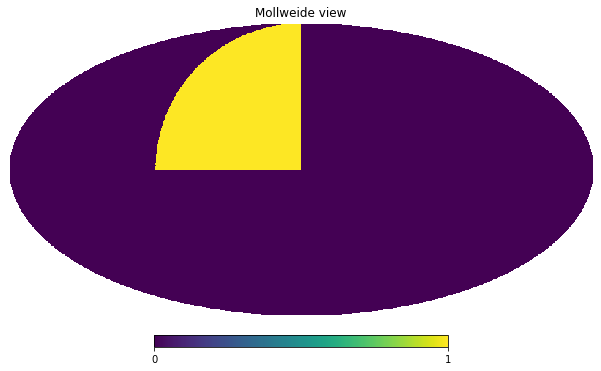

In [10]:
dec_pixels, ra_pixels = hp.pix2ang(512, range(512*512*12))
mask_octant = np.where((dec_pixels < np.pi*0.5)&(ra_pixels<0.5*np.pi)*(ra_pixels > 0), 1., 0.)
hp.mollview(mask_octant)

### Use raytrace function for single source galaxy plane

In [11]:
map_kappa = lensing.raytrace(cosmo_taka.H0, cosmo_taka.Om0,
                             overdensity_array=overdensity_array[:source_edge_index].T,
                             a_centre=1./(1.+z_centre[:source_edge_index]),
                             comoving_edges=cosmo_taka.comoving_distance(z_bin_edges)[:(source_edge_index+1)])

# Compare with Takahashi example (which used GRayTrix)

In [12]:
kappa_taka_test = np.load('takahashi_mock_example/kappa_taka_test_20.npy')

### Smooth maps for visualisation

In [13]:
smooth_map_kappa = hp.smoothing(map_kappa*mask_octant, sigma=np.deg2rad(5./60), verbose=False)
smooth_map_taka = hp.smoothing(kappa_taka_test*mask_octant, sigma=np.deg2rad(5./60), verbose=False)

/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_over(newcm(1.0))
/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  newcm.set_under(bgcolor)
/global/homes/u/ucapnje/.local/cori/3.7-anaconda-2019.10/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifyi

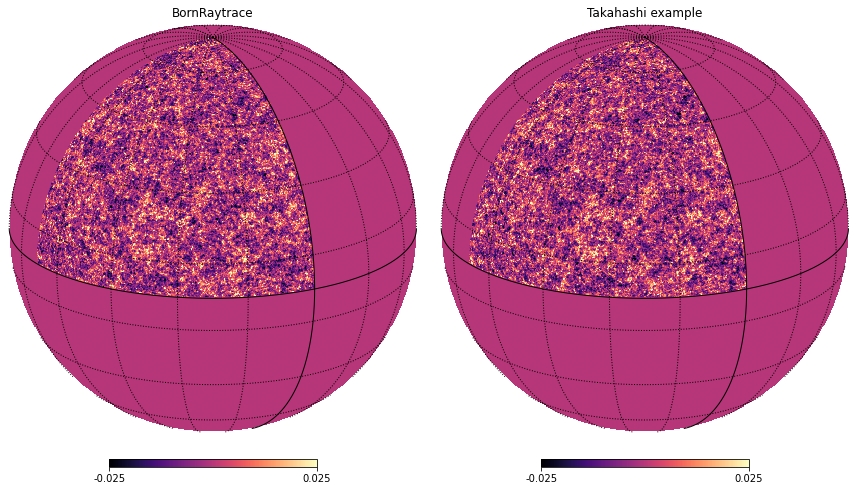

In [14]:
plot_map_pairs(smooth_map_kappa, smooth_map_taka)

### Compare with angular power spectrum (factor of 8 for sky fraction:  $1/f_{sky}$)

In [15]:
cell_kappa = 8. * hp.anafast(map_kappa*mask_octant, lmax=1024)
cell_kappa_taka = 8. *  hp.anafast(kappa_taka_test*mask_octant, lmax=1024)
cell = np.arange(len(cell_kappa))

In [16]:
%%capture
ell_t, cl_t = np.load('takahashi_mock_example/cl_example.npy')
kappa_synfast = hp.synfast(cl_t, nside=1024)
cl_t_corrected = hp.anafast(hp.ud_grade(kappa_synfast,512), lmax=1024)

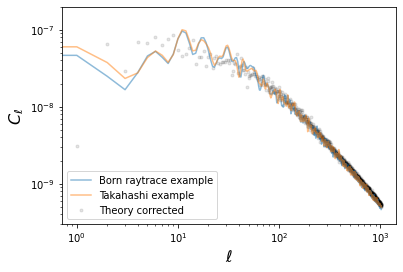

In [17]:
plt.loglog(range(len(cell_kappa)), cell_kappa,label='Born raytrace example', alpha=0.5)
plt.loglog(range(len(cell_kappa)), cell_kappa_taka,label='Takahashi example', alpha=0.5)
plt.scatter(range(len(cell_kappa)), cl_t_corrected, label='Theory corrected',
            alpha=0.1, marker='.', c='black')
plt.ylim(3e-10,2e-7), plt.legend()
plt.ylabel(r'$C_\ell$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)
plt.savefig('plots/cell_test_theory.png', dpi=300)